# Notebook for getting results of model
Will probably be integrated into 02_fine_tune_passt, but for now I didn't want to interrupt the training.

**Purpose of notebook is:**
1. Aggregate our predictions to one predction per file
  1. Trying majority voting, softmax(sum(logits)), or greedy method
  2. Running the model on the test dataset
  3. Output file for leaderboard

## Imports and setup

In [2]:
#%pip install -e 'src/hear21passt' 
%pip install -e 'src/hear21passt'

Obtaining file:///root/data/exploratory_notebooks/da/src/hear21passt
  Preparing metadata (setup.py) ... done
  Attempting uninstall: hear21passt
    Found existing installation: hear21passt 0.0.23
    Uninstalling hear21passt-0.0.23:
      Successfully uninstalled hear21passt-0.0.23
  Running setup.py develop for hear21passt
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Hack: kill the process to restart the kernel and load packages
import os
os._exit(00)

### Imports

In [1]:
import os

import torch
import pandas as pd
import tqdm

from torch.optim import AdamW
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
from torch.nn import functional as F

from utils.model import get_pretrained_passt_model

from utils.gdsc22_dataset_legacy import BuzzDataset

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Constants

In [2]:
!ls ../../checkpoints/

gdsc22_passt_kd_NOEXP_lr_mismatch_size_t40_f4_epochs40_gain_roll_mixup_noise@2023-07-12T16:26:10.pt
gdsc22_passt_kd_NOEXP_lr_mismatch_size_t40_f4_epochs40_gain_roll_mixup_noise@2023-07-12T17:01:22.pt
gdsc22_passt_kd_NOEXP_lr_mismatch_size_t40_f4_epochs40_gain_roll_mixup_noise@2023-07-12T17:16:51.pt
gdsc22_passt_kd_NOEXP_lr_mismatch_size_t40_f4_epochs40_gain_roll_mixup_noise@2023-07-12T17:28:35.pt
gdsc22_passt_kd_explr_t40_f4_45epochs@2023-07-06T08:17:35.pt
gdsc22_passt_kd_explr_t40_f4_45epochs_augmented_train@2023-07-10T17:13:39.pt
gdsc22_passt_kd_explr_t40_f4_45epochs_augmented_train@2023-07-11T09:39:09.pt
gdsc22_passt_kd_t40_f4@2023-07-05T17:40:28.pt
gdsc22_passt_swa_explr_t40_f4@2023-07-06T06:53:42.pt
gdsc22_passt_swa_explr_t40_f4@2023-07-06T07:40:26.pt
gdsc22_passt_swa_t40_f4.pt
gdsc22_past_swa_t10_f3.pt


In [3]:
# Locations
base_dir = os.path.abspath(os.path.join(os.getcwd(), '../../data_processed'))
base_dir = os.path.abspath(os.path.join(os.getcwd(), '../../gdsc_data/data_processed/data_fe58528/1_downsampled_split'))
val_dir = os.path.join(base_dir, 'val/')
test_dir = os.path.join(base_dir, 'test/')

# Which model to test
MODEL_NAME = "gdsc22_passt_t40_f4.pt"
#MODEL_NAME = 'gdsc22_passt_t10_f3.pt'
MODEL_NAME = 'gdsc22_passt_kd_NOEXP_lr_mismatch_size_t40_f4_epochs40_gain_roll_mixup_noise@2023-07-12T17:28:35.pt'

# Helper for storing the results
mname = MODEL_NAME[0:MODEL_NAME.rfind(".")]
print(mname)

gdsc22_passt_kd_NOEXP_lr_mismatch_size_t40_f4_epochs40_gain_roll_mixup_noise@2023-07-12T17:28:35


### Define dataloaders

In [4]:
val_dataset = BuzzDataset(val_dir, metadata_csv=os.path.join(val_dir, 'metadata.csv'))
val_dataloader = DataLoader(val_dataset, batch_size=30)
#val_dataloader = DataLoader(val_dataset, batch_size=4) # tmp for testing

In [5]:
test_dataset = BuzzDataset(test_dir, metadata_csv=os.path.join(test_dir, 'metadata.csv'))
test_dataloader = DataLoader(test_dataset, batch_size=30)
#test_dataloader = DataLoader(test_dataset, batch_size=4) # Tmp for testing

## Load the model

In [6]:
TORCH_SAVE_PATH = os.path.abspath(os.path.join(os.getcwd(), f'../../checkpoints/{MODEL_NAME}'))

#model_eval = get_pretrained_passt_model(mode="all", n_classes=66, s_patchout_t=0, s_patchout_f=0, debug=False)
model_eval = get_pretrained_passt_model(mode="all", n_classes=66, s_patchout_t=0, s_patchout_f=0)
state = torch.load(TORCH_SAVE_PATH)
model_eval.load_state_dict(state['model_state_dict'])



 Loading PaSST pre-trained on AudioSet (with KD) Patch 16 stride 10 structured patchout mAP=486 


PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
   

<All keys matched successfully>

In [7]:
model_eval = model_eval.cuda() if torch.cuda.is_available() else model_eval.cpu() 

# Run predictions on validation
Remember to remobe cnt, break, and .cuda() when running the real model

In [8]:
val_loss = 0.0
ypred_f1 = []
ytrue_f1 = []
fnames_val = []
model_eval.eval()
probs_list_val = []

cnt = 0
with torch.no_grad():
    for batch, y_val, fname in tqdm.tqdm(val_dataloader):
        
        cnt = cnt + 1
        #if cnt > 3:
        #    break
        
        fnames_val.append(fname)
        batch = batch.cuda()
        y_val = y_val.cuda()

        y_hat, emb = model_eval(batch)
        _loss = F.cross_entropy(y_hat, y_val, reduction="none")

        prob = F.softmax(y_hat, dim=1)
        
        probs_list_val.append(prob.cpu())
        
        y_pred = torch.argmax(prob, dim=1)

        ypred_f1.append(y_pred.cpu())
        ytrue_f1.append(y_val.cpu())

        val_loss += _loss.sum()

# No longer needed I think - Will depends on how we aggregate our predictions
#f1_score_val = f1_score(torch.cat(ytrue_f1).numpy(), torch.cat(ypred_f1).numpy(), average='macro')
#print(f"Val Loss: {val_loss}")
#print(f"=" * 80)
#print(f"F1 score(val) {f1_score_val}")
#print(f"=" * 80)

  0%|          | 0/68 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/functional.py:632: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:801.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]
/root/data/exploratory_notebooks/da/src/hear21passt/hear21passt/models/passt.py:292: UserWarning: Input image size (128*1000) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


x torch.Size([30, 1, 128, 1000])
self.norm(x) torch.Size([30, 768, 12, 99])
 patch_embed :  torch.Size([30, 768, 12, 99])
 self.time_new_pos_embed.shape torch.Size([1, 768, 1, 99])
 self.freq_new_pos_embed.shape torch.Size([1, 768, 12, 1])
X flattened torch.Size([30, 1188, 768])
 self.new_pos_embed.shape torch.Size([1, 2, 768])
 self.cls_tokens.shape torch.Size([30, 1, 768])
 self.dist_token.shape torch.Size([30, 1, 768])
 final sequence x torch.Size([30, 1190, 768])
 after 12 atten blocks x torch.Size([30, 1190, 768])
forward_features torch.Size([30, 768])
head torch.Size([30, 66])


100%|██████████| 68/68 [03:54<00:00,  3.44s/it]


# Gather predictions to a dataframe

In [14]:
# Get the probabilities for each class
df = pd.DataFrame(torch.cat(probs_list_val).numpy(), columns = list(range(0,66,1)))

# Append filename and true class. (True class only for validation). needs rewriting for test dataset
df['fname'] = [item for t in fnames_val for item in t]
df['y_true'] = torch.cat(ytrue_f1).numpy()

# Reorder - Can be done a lot cleaner
cols = df.columns.tolist()
cols = cols[-2:] + cols[:-2]
df = df[cols]

# Split the fname, so we know which files were chunked together
def splitter(txt):
    x = txt.rfind("_")
    y = txt.rfind(".")
    original_file = txt[0:x] + txt[y:len(txt)]
    #chunk_no = int(txt[x+1:y])
    chunk_no = txt[x+1:y] # Should be int, but broken because of reasons. Will be fixed when data_processed is recreated
    return original_file, chunk_no

# Create helper
df['tmp'] = df['fname'].apply(splitter)

# Create new columns
new_col_list = ['original_filename', 'chunk_no']
for n,col in enumerate(new_col_list):
    df[col] = df['tmp'].apply(lambda tmp: tmp[n])

# Clean up my own mess
df = df.drop('tmp',axis=1)

cols = df.columns.tolist()
cols = cols[-2:] + cols[:-2]
df = df[cols]

df.to_csv(os.path.join('results', mname + '_validation_probs.csv')) # save temporarily, so rest can run on cheaper instance
df

,original_filename,chunk_no,fname,y_true,0,1,2,3,4,5,...,56,57,58,59,60,61,62,63,64,65
0,Atrapsaltacorticina_GBIF2901504947_IN62966536_...,1,Atrapsaltacorticina_GBIF2901504947_IN62966536_...,3,0.001204,0.027645,0.001816,0.179040,0.009634,0.001938,...,0.005278,0.002359,0.001371,0.224323,0.003273,0.000616,0.001294,0.004053,0.006721,0.005240
1,Atrapsaltacorticina_GBIF2901504947_IN62966536_...,2,Atrapsaltacorticina_GBIF2901504947_IN62966536_...,3,0.001545,0.070227,0.001813,0.047943,0.011978,0.000585,...,0.009336,0.006022,0.003654,0.116457,0.001495,0.001226,0.001613,0.001937,0.033462,0.002199
2,Chorthippusbrunneus_XC751398-dat022-008.wav,edit5,Chorthippusbrunneus_XC751398-dat022-008_edit5.wav,10,0.000602,0.001072,0.000264,0.001129,0.001618,0.001117,...,0.000528,0.001461,0.000870,0.000552,0.006118,0.001442,0.000101,0.000543,0.000640,0.000478
3,Psaltodaplaga_GBIF3031797565_IN68469430.wav,159997,Psaltodaplaga_GBIF3031797565_IN68469430_159997...,53,0.000449,0.002975,0.001128,0.009710,0.000795,0.000206,...,0.000315,0.000132,0.000286,0.000402,0.000632,0.000300,0.000242,0.001104,0.001419,0.001233
4,Omocestusviridulus_XC752267-dat013-003_edit2.wav,1,Omocestusviridulus_XC752267-dat013-003_edit2_1...,39,0.000047,0.000013,0.000124,0.000005,0.000027,0.000010,...,0.000032,0.000010,0.000020,0.000018,0.000157,0.000197,0.000070,0.000027,0.000021,0.000014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,Platycleisalbopunctata_XC751607-dat028-009.wav,4,Platycleisalbopunctata_XC751607-dat028-009_4.wav,45,0.000180,0.000238,0.000067,0.000066,0.000244,0.000084,...,0.000105,0.000042,0.000021,0.000040,0.000254,0.000062,0.000052,0.000019,0.000222,0.000577
2014,Platycleisalbopunctata_XC751607-dat028-009.wav,5,Platycleisalbopunctata_XC751607-dat028-009_5.wav,45,0.000187,0.000315,0.000084,0.000081,0.000289,0.000118,...,0.000135,0.000069,0.000034,0.000054,0.000312,0.000103,0.000078,0.000026,0.000234,0.000547
2015,Platycleisalbopunctata_XC751607-dat028-009.wav,6,Platycleisalbopunctata_XC751607-dat028-009_6.wav,45,0.000146,0.000266,0.000069,0.000077,0.000246,0.000094,...,0.000132,0.000047,0.000023,0.000046,0.000322,0.000084,0.000040,0.000016,0.000209,0.000649
2016,Platycleisalbopunctata_XC751607-dat028-009.wav,7,Platycleisalbopunctata_XC751607-dat028-009_7.wav,45,0.000118,0.000388,0.000088,0.000100,0.000354,0.000125,...,0.000134,0.000073,0.000033,0.000039,0.000568,0.000124,0.000061,0.000023,0.000240,0.000820


In [15]:
# Averaging over proabilities
df_val_avg = df.groupby(['original_filename', 'y_true'])[list(range(0,66,1))].mean().idxmax(axis='columns').reset_index()
#df.groupby(['original_filename', 'y_true'])[list(range(1,67,1))].mean()#.to_csv('tmp.csv')
df_val_avg.columns = ['original_filename', 'y_true', 'y_pred']

# Save 
df_val_avg.to_csv(os.path.join('results', mname + '_validation_predictions_mean.csv')) # save temporarily, so rest can run on cheaper instance
df_val_avg

,original_filename,y_true,y_pred
0,Achetadomesticus_XC751734-dat001-055_edit1.wav,0,0
1,Achetadomesticus_XC751734-dat001-055_edit2.wav,0,0
2,Achetadomesticus_XC751734-dat001-055_edit3.wav,0,0
3,Achetadomesticus_XC751734-dat001-055_edit4.wav,0,0
4,Achetadomesticus_XC751736-dat001-057.wav,0,0
...,...,...,...
442,Yoyettarepetens_GBIF1978855326_IN19219004_2860...,65,65
443,Yoyettarepetens_GBIF2005327021_IN20313139.wav,65,65
444,Yoyettarepetens_GBIF2445036234_IN34812353_4912...,65,65
445,Yoyettarepetens_GBIF2465318314_IN36334636.wav,65,64


In [16]:
# Greedy - Find the most confident one
df_val_max = df.groupby(['original_filename', 'y_true'])[list(range(0,66,1))].max().idxmax(axis='columns').reset_index()
df_val_max.columns = ['original_filename', 'y_true', 'y_pred']

df_val_max.to_csv(os.path.join('results', mname + '_validation_predictions_max.csv')) # save temporarily, so rest can run on cheaper instance
df_val_max

,original_filename,y_true,y_pred
0,Achetadomesticus_XC751734-dat001-055_edit1.wav,0,0
1,Achetadomesticus_XC751734-dat001-055_edit2.wav,0,0
2,Achetadomesticus_XC751734-dat001-055_edit3.wav,0,0
3,Achetadomesticus_XC751734-dat001-055_edit4.wav,0,0
4,Achetadomesticus_XC751736-dat001-057.wav,0,0
...,...,...,...
442,Yoyettarepetens_GBIF1978855326_IN19219004_2860...,65,65
443,Yoyettarepetens_GBIF2005327021_IN20313139.wav,65,65
444,Yoyettarepetens_GBIF2445036234_IN34812353_4912...,65,65
445,Yoyettarepetens_GBIF2465318314_IN36334636.wav,65,64


### Skipping F1 calculations right now, as I don't have the results. 
but this should be the basis

That's a lie... now taking a look:

In [17]:
print("By averaging:")
f1_score_val = f1_score(df_val_avg.y_true, df_val_avg.y_pred, average='macro')

print(f"Val Loss: {val_loss}")
print(f"=" * 80)
print(f"F1 score(val) {f1_score_val}")
print(f"=" * 80)

By averaging:
Val Loss: 1011.6996459960938
F1 score(val) 0.844791827955854


In [18]:
print("By greedy:")
f1_score_val = f1_score(df_val_max.y_true, df_val_max.y_pred, average='macro')

print(f"Val Loss: {val_loss}")
print(f"=" * 80)
print(f"F1 score(val) {f1_score_val}")
print(f"=" * 80)

By greedy:
Val Loss: 1011.6996459960938
F1 score(val) 0.8476282592013761


## See if we can run predictions on test dataset

In [9]:
ypred_f1 = []
ytrue_f1 = []
fnames_test = []
probs_list_test = []

model_eval.eval()

cnt = 0
with torch.no_grad():
    for batch, fname in tqdm.tqdm(test_dataloader):
        cnt = cnt + 1
        #if cnt > 2:
        #    break
            
        fnames_test.append(fname)
        batch = batch.cuda()
        
        y_hat, emb = model_eval(batch)
        
        prob = F.softmax(y_hat, dim=1)
        
        probs_list_test.append(prob.cpu())
        
        y_pred = torch.argmax(prob, dim=1)

        ypred_f1.append(y_pred.cpu())

100%|██████████| 58/58 [03:08<00:00,  3.25s/it]


### Gather results to a csv

In [11]:
# Get the probabilities for each class
df_test = pd.DataFrame(torch.cat(probs_list_test).numpy(), columns = list(range(0,66,1)))

# Append filename
df_test['fname'] = [item for t in fnames_test for item in t]

# Reorder - Can be done a lot cleaner
cols = df_test.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_test = df_test[cols]


# Split the fname, so we know which files were chunked together
def splitter(txt):
    x = txt.rfind("_")
    y = txt.rfind(".")
    original_file = txt[0:x] + txt[y:len(txt)]
    #chunk_no = int(txt[x+1:y])
    chunk_no = txt[x+1:y] # Should be int, but broken because of reasons. Will be fixed when data_processed is recreated
    return original_file, chunk_no

# Create helper
df_test['tmp'] = df_test['fname'].apply(splitter)

# Create new columns
new_col_list = ['original_filename', 'chunk_no']
for n,col in enumerate(new_col_list):
    df_test[col] = df_test['tmp'].apply(lambda tmp: tmp[n])

# Clean up my own mess
df_test = df_test.drop('tmp',axis=1)

cols = df_test.columns.tolist()
cols = cols[-2:] + cols[:-2]
df_test = df_test[cols]

df_test.to_csv(os.path.join('results', mname + '_test_probs.csv')) # save temporarily, so rest can run on cheaper instance
df_test

,original_filename,chunk_no,fname,0,1,2,3,4,5,6,...,56,57,58,59,60,61,62,63,64,65
0,0.wav,1,0_1.wav,0.000352,0.000297,0.000894,0.001819,0.017019,0.000498,0.000757,...,0.000958,0.000314,0.000172,0.000222,0.000263,0.004888,0.000525,0.000341,0.006483,0.002331
1,1.wav,1,1_1.wav,0.002151,0.010618,0.000576,0.001390,0.001298,0.002239,0.064819,...,0.009779,0.000363,0.042628,0.008793,0.305298,0.012821,0.001943,0.006097,0.002840,0.001691
2,2.wav,1,2_1.wav,0.004365,0.008049,0.001449,0.001354,0.002351,0.002539,0.002204,...,0.002295,0.000328,0.002309,0.005287,0.224934,0.009565,0.003511,0.005923,0.002807,0.000316
3,2.wav,2,2_2.wav,0.002543,0.009963,0.001451,0.000496,0.000480,0.000815,0.005168,...,0.003056,0.000379,0.009348,0.000499,0.083817,0.002483,0.005986,0.001373,0.002648,0.000411
4,2.wav,3,2_3.wav,0.001304,0.022082,0.001026,0.000538,0.000294,0.000454,0.005502,...,0.004165,0.000440,0.003028,0.000510,0.047699,0.006417,0.002426,0.001605,0.003985,0.000477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727,554.wav,1,554_1.wav,0.000384,0.000074,0.000093,0.000176,0.000170,0.000838,0.000085,...,0.000991,0.000546,0.000177,0.000187,0.000392,0.000088,0.000264,0.000743,0.001380,0.000155
1728,554.wav,2,554_2.wav,0.000241,0.000025,0.000033,0.000042,0.000056,0.000473,0.000048,...,0.000688,0.000578,0.000085,0.000058,0.000146,0.000050,0.000108,0.000195,0.000980,0.000036
1729,554.wav,3,554_3.wav,0.004856,0.003994,0.000690,0.004155,0.001298,0.067700,0.000872,...,0.001394,0.000991,0.006258,0.019075,0.003160,0.003577,0.001324,0.017894,0.007767,0.002069
1730,555.wav,1,555_1.wav,0.002284,0.001731,0.000045,0.000203,0.000865,0.000184,0.000059,...,0.003675,0.000272,0.000374,0.000413,0.001261,0.000431,0.000493,0.000766,0.001036,0.000301


In [13]:
# Averaging over proabilities
df_test_avg = df_test.groupby(['original_filename'])[list(range(0,66,1))].mean().idxmax(axis='columns').reset_index()
#df.groupby(['original_filename', 'y_true'])[list(range(1,67,1))].mean()#.to_csv('tmp.csv')
df_test_avg.columns = ['file_name', 'predicted_class_id']

# Save 
df_test_avg.to_csv(os.path.join('results', mname + '_test_predictions_mean.csv'), index=False) # save temporarily, so rest can run on cheaper instance
df_test_avg

,file_name,predicted_class_id
0,0.wav,14
1,1.wav,60
2,10.wav,9
3,100.wav,56
4,101.wav,59
...,...,...
551,95.wav,21
552,96.wav,43
553,97.wav,12
554,98.wav,23


# Taking a look at class imbalances?

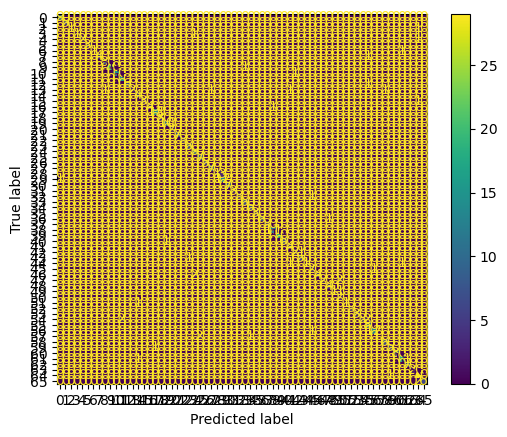

In [22]:
import sklearn
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(df_val_avg.y_true, df_val_avg.y_pred)

disp = sklearn.metrics.ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

# Check if hierachical makes any sense
TL;Dr: No it doesn't

In [23]:
import os

#import torch
import pandas as pd
import tqdm

#from torch.optim import AdamW
#from torch.utils.data import DataLoader
from sklearn.metrics import f1_score

import sklearn
import matplotlib.pyplot as plt
#from torch.nn import functional as F

#from utils.model import get_pretrained_passt_model

#from utils.gdsc22_dataset import BuzzDataset

In [24]:
df_val_pred = pd.read_csv((os.path.join('results', mname + '_validation_predictions_mean.csv')), index_col='Unnamed: 0')
df_val_pred

,original_filename,y_true,y_pred
0,Achetadomesticus_XC751734-dat001-055_edit1.wav,0,0
1,Achetadomesticus_XC751734-dat001-055_edit2.wav,0,0
2,Achetadomesticus_XC751734-dat001-055_edit3.wav,0,0
3,Achetadomesticus_XC751734-dat001-055_edit4.wav,0,0
4,Achetadomesticus_XC751736-dat001-057.wav,0,0
...,...,...,...
442,Yoyettarepetens_GBIF1978855326_IN19219004_2860...,65,65
443,Yoyettarepetens_GBIF2005327021_IN20313139.wav,65,65
444,Yoyettarepetens_GBIF2445036234_IN34812353_4912...,65,65
445,Yoyettarepetens_GBIF2465318314_IN36334636.wav,65,64


In [25]:
df_input_data = pd.read_csv('../../exploratory_notebooks/gsk/input_data/data_for_augmentation.csv', index_col=False)

def splitter2(txt):
    x = txt.rfind('(')
    y = txt.rfind(')')

    species = txt[0:x]
    #print(species)
    lbl = txt[x+1:y]
    #print(lbl)
    return species, lbl

df_input_data['tmp'] = df_input_data['species and label'].apply(splitter2)

new_col_list = ['species', 'label']
for n,col in enumerate(new_col_list):
    df_input_data[col] = df_input_data['tmp'].apply(lambda tmp: tmp[n])
    
df_input_data['label'] = pd.to_numeric(df_input_data['label'])
    
# Clean up my own mess
df_input_data = df_input_data.drop('tmp',axis=1)

cols = df_input_data.columns.tolist()
cols = cols[-2:] + cols[:-2]
df_input_data = df_input_data[cols]

# Fix known errors
df_input_data['Suborder:'].fillna('Auchenorrhyncha', inplace=True)
df_input_data['Family:'].fillna('Acrididae', inplace=True)



df_input_data

,species,label,RN,species and label,Method,Common Name,Order:,Suborder:,Family:,Genus:,Species:,Species (GSK)
0,Atrapsaltacollina,2,3,Atrapsaltacollina (2),Tymbals,NaN,Hemiptera,Auchenorrhyncha,Cicadidae,Atrapsalta,NaN,Atrapsalta collina
1,Atrapsaltacorticina,3,4,Atrapsaltacorticina (3),Tymbals,NaN,Hemiptera,Auchenorrhyncha,Cicadidae,Atrapsalta,NaN,Atrapsalta corticina
2,Atrapsaltaencaustica,4,5,Atrapsaltaencaustica (4),Tymbals,NaN,Hemiptera,Auchenorrhyncha,Cicadidae,Atrapsalta,NaN,Atrapsalta encaustica
3,Aleetacurvicosta,1,2,Aleetacurvicosta (1),Tymbals,Floury Baker,Hemiptera,Auchenorrhyncha,Cicadidae,Cicadettinae,Lamotialnini,Aleeta curvicosta
4,Diceroproctaeugraphica,20,21,Diceroproctaeugraphica (20),Tymbals,NaN,Hemiptera,Auchenorrhyncha,Cicadidae,Diceroprocta,D. eugraphica,Diceroprocta eugraphica
...,...,...,...,...,...,...,...,...,...,...,...,...
61,Ruspolianitidula,57,58,Ruspolianitidula (57),Stridulation,NaN,Orthoptera,Ensifera,Tettigoniidae,Ruspolia,R. nitidula,Ruspolia nitidula
62,Tettigoniacantans,61,62,Tettigoniacantans (61),Stridulation,NaN,Orthoptera,Ensifera,Tettigoniidae,Tettigonia,T. cantans,Tettigonia cantans
63,Tettigoniaviridissima,62,63,Tettigoniaviridissima (62),Stridulation,Great green bush-cricket,Orthoptera,Ensifera,Tettigoniidae,Tettigonia,T. viridissima,Tettigonia viridissima
64,Tylopsislilifolia,63,64,Tylopsislilifolia (63),Stridulation,lily bush-cricket,Orthoptera,Ensifera,Tettigoniidae,Tylopsis,T. lilifolia,Tylopsis lilifolia


## Check for order

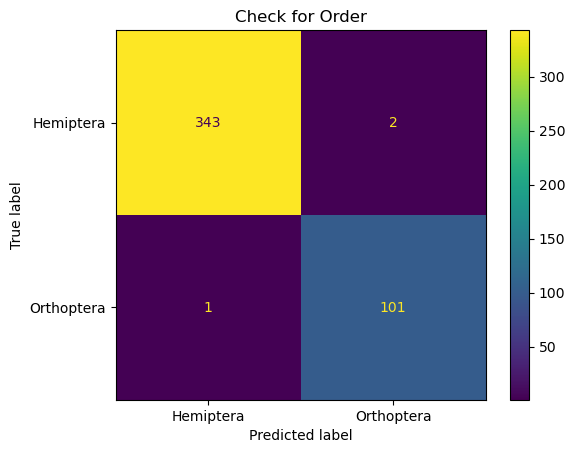

,original_filename,y_true,y_pred,y_true_Method,y_pred_Method
0,Achetadomesticus_XC751734-dat001-055_edit1.wav,0,0,Stridulation,Stridulation
1,Achetadomesticus_XC751734-dat001-055_edit2.wav,0,0,Stridulation,Stridulation
2,Achetadomesticus_XC751734-dat001-055_edit3.wav,0,0,Stridulation,Stridulation
3,Achetadomesticus_XC751734-dat001-055_edit4.wav,0,0,Stridulation,Stridulation
4,Achetadomesticus_XC751736-dat001-057.wav,0,0,Stridulation,Stridulation
...,...,...,...,...,...
442,Yoyettarepetens_GBIF1950028169_IN18992513.wav,65,65,Tymbals,Tymbals
443,Yoyettarepetens_GBIF1978820758_IN19037335.wav,65,65,Tymbals,Tymbals
444,Yoyettarepetens_GBIF1978855326_IN19219004_2860...,65,65,Tymbals,Tymbals
445,Yoyettarepetens_GBIF2005327021_IN20313139.wav,65,65,Tymbals,Tymbals


In [26]:
# Get method for true
merged_df = pd.merge(df_val_pred, df_input_data[['label', 'Method']], left_on='y_true', right_on='label')
merged_df = merged_df.drop('label', axis=1)
merged_df.rename(columns={"Method": "y_true_Method"}, inplace=True)


# Get method for prediction
merged_df = pd.merge(merged_df, df_input_data[['label', 'Method']], left_on='y_pred', right_on='label')
merged_df = merged_df.drop('label', axis=1)
merged_df.rename(columns={"Method": "y_pred_Method"}, inplace=True)

cm = sklearn.metrics.confusion_matrix(merged_df.y_true_Method, merged_df.y_pred_Method)

disp = sklearn.metrics.ConfusionMatrixDisplay(cm, display_labels=['Hemiptera', 'Orthoptera'])
disp.plot()
disp.ax_.set_title("Check for Order")
plt.show()

merged_df

## Check for Suborder

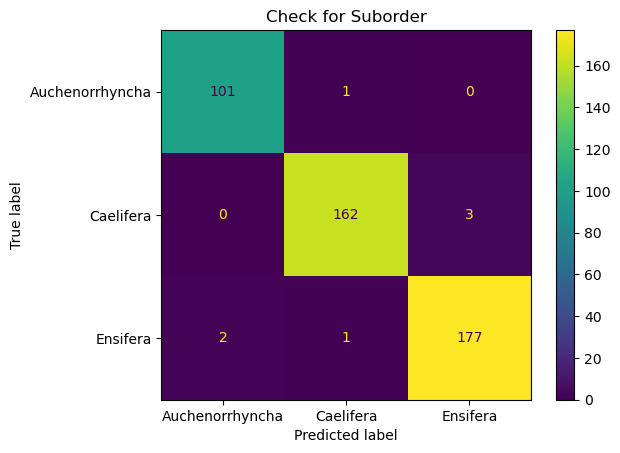

,original_filename,y_true,y_pred,y_true_h,y_pred_h
0,Achetadomesticus_XC751734-dat001-055_edit1.wav,0,0,Ensifera,Ensifera
1,Achetadomesticus_XC751734-dat001-055_edit2.wav,0,0,Ensifera,Ensifera
2,Achetadomesticus_XC751734-dat001-055_edit3.wav,0,0,Ensifera,Ensifera
3,Achetadomesticus_XC751734-dat001-055_edit4.wav,0,0,Ensifera,Ensifera
4,Achetadomesticus_XC751736-dat001-057.wav,0,0,Ensifera,Ensifera
...,...,...,...,...,...
442,Yoyettarepetens_GBIF1950028169_IN18992513.wav,65,65,Auchenorrhyncha,Auchenorrhyncha
443,Yoyettarepetens_GBIF1978820758_IN19037335.wav,65,65,Auchenorrhyncha,Auchenorrhyncha
444,Yoyettarepetens_GBIF1978855326_IN19219004_2860...,65,65,Auchenorrhyncha,Auchenorrhyncha
445,Yoyettarepetens_GBIF2005327021_IN20313139.wav,65,65,Auchenorrhyncha,Auchenorrhyncha


In [27]:
# Get method for true
merged_df = pd.merge(df_val_pred, df_input_data[['label', 'Suborder:']], left_on='y_true', right_on='label')
merged_df = merged_df.drop('label', axis=1)
merged_df.rename(columns={"Suborder:": "y_true_h"}, inplace=True)


# Get method for prediction
merged_df = pd.merge(merged_df, df_input_data[['label', 'Suborder:']], left_on='y_pred', right_on='label')
merged_df = merged_df.drop('label', axis=1)
merged_df.rename(columns={"Suborder:": "y_pred_h"}, inplace=True)

cm = sklearn.metrics.confusion_matrix(merged_df.y_true_h, merged_df.y_pred_h)

disp = sklearn.metrics.ConfusionMatrixDisplay(cm, display_labels=['Auchenorrhyncha', 'Caelifera', 'Ensifera'])
disp.plot(values_format = '0')
disp.ax_.set_title("Check for Suborder")
plt.show()

merged_df

## Check for Family

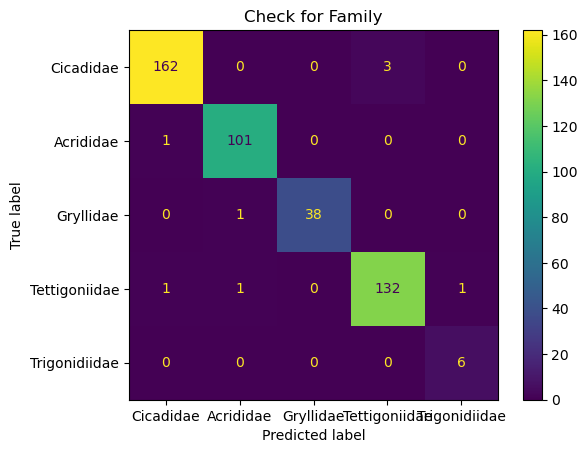

,original_filename,y_true,y_pred,y_true_h,y_pred_h
0,Achetadomesticus_XC751734-dat001-055_edit1.wav,0,0,Gryllidae,Gryllidae
1,Achetadomesticus_XC751734-dat001-055_edit2.wav,0,0,Gryllidae,Gryllidae
2,Achetadomesticus_XC751734-dat001-055_edit3.wav,0,0,Gryllidae,Gryllidae
3,Achetadomesticus_XC751734-dat001-055_edit4.wav,0,0,Gryllidae,Gryllidae
4,Achetadomesticus_XC751736-dat001-057.wav,0,0,Gryllidae,Gryllidae
...,...,...,...,...,...
442,Yoyettarepetens_GBIF1950028169_IN18992513.wav,65,65,Cicadidae,Cicadidae
443,Yoyettarepetens_GBIF1978820758_IN19037335.wav,65,65,Cicadidae,Cicadidae
444,Yoyettarepetens_GBIF1978855326_IN19219004_2860...,65,65,Cicadidae,Cicadidae
445,Yoyettarepetens_GBIF2005327021_IN20313139.wav,65,65,Cicadidae,Cicadidae


In [28]:
# Get method for true
merged_df = pd.merge(df_val_pred, df_input_data[['label', 'Family:']], left_on='y_true', right_on='label')
merged_df = merged_df.drop('label', axis=1)
merged_df.rename(columns={"Family:": "y_true_h"}, inplace=True)


# Get method for prediction
merged_df = pd.merge(merged_df, df_input_data[['label', 'Family:']], left_on='y_pred', right_on='label')
merged_df = merged_df.drop('label', axis=1)
merged_df.rename(columns={"Family:": "y_pred_h"}, inplace=True)

cm = sklearn.metrics.confusion_matrix(merged_df.y_true_h, merged_df.y_pred_h)

disp = sklearn.metrics.ConfusionMatrixDisplay(cm, display_labels=['Cicadidae', 'Acrididae', 'Gryllidae', 'Tettigoniidae', 'Trigonidiidae'])
disp.plot(values_format = '0')
disp.ax_.set_title("Check for Family")
plt.show()

merged_df

